In [60]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
sns.set_style('whitegrid')

from plotly import tools
import plotly_express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

#Preprocessing
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from scipy.stats import uniform

#MODELS
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
import xgboost as xgb
from xgboost import XGBRegressor
from bayes_opt import BayesianOptimization

#CLASSICAL STATS
import scipy
import statsmodels
from scipy.stats import boxcox
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
#!pip install fbprophet
#from fbprophet import Prophet
from statsmodels.tsa.statespace import sarimax
from statsmodels.tsa.seasonal import seasonal_decompose

#DEEP LEARNING LIB
from keras.models import Model,Sequential
from keras.utils import np_utils, to_categorical
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from tensorflow.keras.utils import plot_model
import itertools
import lightgbm as lgb

#METRICS
from sklearn.metrics import accuracy_score, confusion_matrix,classification_report, r2_score,mean_absolute_error,mean_squared_error

from random import randrange
import warnings 
warnings.filterwarnings('ignore')

In [61]:
df = pd.read_csv('ForecastingProject.csv')
print('DATASET SHAPE: ', df.shape)
df.head()

DATASET SHAPE:  (237, 2)


,DATE,Actual_sales
0,1/1/2001,31657
1,2/1/2001,29913
2,3/1/2001,33084
3,4/1/2001,31911
4,5/1/2001,34154


The forecasting dataset provided contains monthly sales of an unknown company from the year 2001 to the beginning of 2020. The dataset is in the shape of 237 x 2.

In [62]:
#show columns
#df.columns = [col.lower() for col in df.columns]
df['DATE'] = pd.to_datetime(df['DATE'])
#df.columns

In [63]:
#get the date and rates of indian rupee
data = df[['DATE', 'Actual_sales']]
data.columns = ['Date', 'Sales']

In [64]:
#show new dataframe
data.head()

,Date,Sales
0,2001-01-01,31657
1,2001-02-01,29913
2,2001-03-01,33084
3,2001-04-01,31911
4,2001-05-01,34154


In [65]:
#show feature data types
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 237 entries, 0 to 236
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    237 non-null    datetime64[ns]
 1   Sales   237 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 3.8 KB


In [66]:
#remove rates with a value of ND
data = data.drop(data[data['Sales']=='ND'].index)
#converte the rates to numeric value
data['Sales'] = pd.to_numeric(data.Sales)
#sort values by date
data = data.sort_values('Date', ascending=True)

In [67]:
#show basic stats
data.Sales.describe()


count      237.000000
mean     43319.907173
std       7688.358827
min      29913.000000
25%      36647.000000
50%      42501.000000
75%      48985.000000
max      70095.000000
Name: Sales, dtype: float64

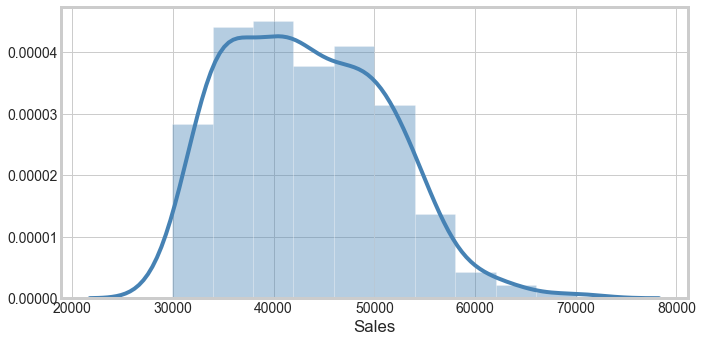

In [68]:
plt.figure(figsize=(10,5))
sns.distplot(data.Sales, bins=10, color='steelblue');

We can see that over the last two year of recorded sales data most of the sales avergae around 40000 sales per month. The minimum for the entire period is 29913 and the maximum is 70000. 

In [69]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=data.Date, y=data.Sales, marker_color='lightgreen'))

fig.update_layout(title='TIME-SERIES PLOT OF SALES', 
                  height=450, width=1000, template='plotly_dark', font_color='lightgreen', 
                  font=dict(family="sans serif",
                            size=16,
                            color="grey"
                            ))

fig.update_xaxes(title='Date')
fig.update_yaxes(title='Sales')
fig.show()

We plot the time series plot for the sales. We can see that the sales been steadily incresing over the last 20 years and have seen a spike in the 2020. We can assume that the sales are related to essential items such as toilet paper and sanitizers since they were one of the few items to have seen a surge in sales. 

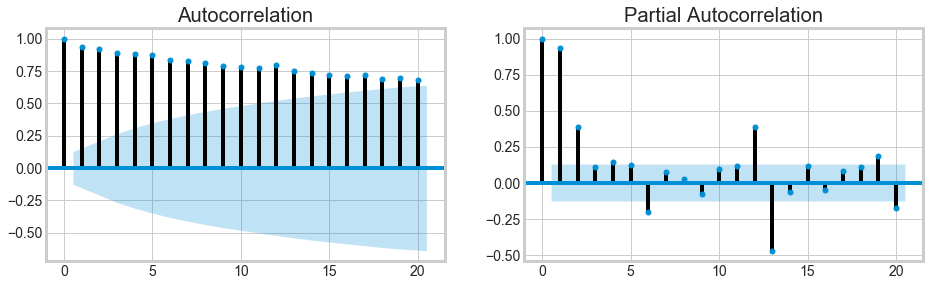

In [70]:
fig, ax = plt.subplots(1,2,figsize=(14,4))
plot_acf(data.Sales, lags=20, ax=ax[0]);
plot_pacf(data.Sales, lags=20, ax=ax[1]);

We plot the ACF and PACF for the data to check for trend and seasonality. In the ACF plot we observe that that the later sales have high correlation with the first few months of sales. And we also see that the series is not stationary since it is decaying. In the PACF plot we observe that only the first lag and the second is correlated with the future sales. 

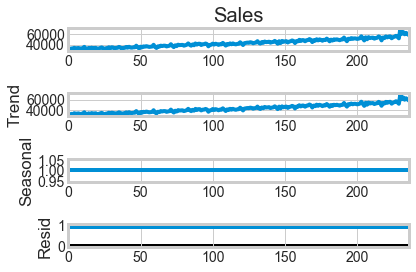

In [71]:
sdec = seasonal_decompose(data.Sales, model='multiplicative', freq=1)
sdec.plot();

We plot the seasonal decomposition using the multiplicative function. We see that the sales see a stead increase to the upside and the trend also follows in a positive side. The seasonal factor is stead and the residual is zero.

In [92]:
X_train, X_val = data[:-24], data[-24:]

print('X_train Shape: ', X_train.shape)
print('X_val Shape: ', X_val.shape)

X_train Shape:  (213, 14)
X_val Shape:  (24, 14)


#### We split the data to train by removing the last 12 months dataset. We then run the SARIMAX function to predict the last 24 months value and compare it to the true value. 

In [93]:
predictions = []

arima = sm.tsa.statespace.SARIMAX(X_train.Sales,order=(1,1,1),seasonal_order=(1,1,1,6),
                                  enforce_stationarity=False, enforce_invertibility=False,).fit()
#get a 24 months prediction
predictions.append(arima.forecast(24))
#converting and reshaping 
predictions = np.array(predictions).reshape((24,))

We run the SARIMAX model with an order of (1,1,1)x(1,1,1,12) because it had the least AIC of all the other combinations

In [94]:
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                             Sales   No. Observations:                  213
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 6)   Log Likelihood               -1583.935
Date:                           Tue, 15 Dec 2020   AIC                           3177.871
Time:                                   11:50:35   BIC                           3194.312
Sample:                                        0   HQIC                          3184.526
                                           - 213                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3980      0.068     -5.834      0.000      -0.532      -0.264
ma.L1         -0.4040      0.041     -9.905      0.000      -0.484      -0.324
ar.S.L6       -0.9859      0.020    -50.201      0.000      -1.024      -0.947
ma.S.L6        0.1148      0.050      2.306      0.021       0.017       0.212
sigma2      4.979e+05   4.61e+04     10.791      0.000    4.07e+05    5.88e+05
===================================================================================
Ljung-Box (Q):                      122.93   Jarque-Bera (JB):                 5.91
Prob(Q):                              0.00   Prob(JB):                         0.05
Heteroskedasticity (H):               1.35   Skew:                            -0.20
Prob(H) (two-sided):                  0.23   Kurtosis:                         3.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

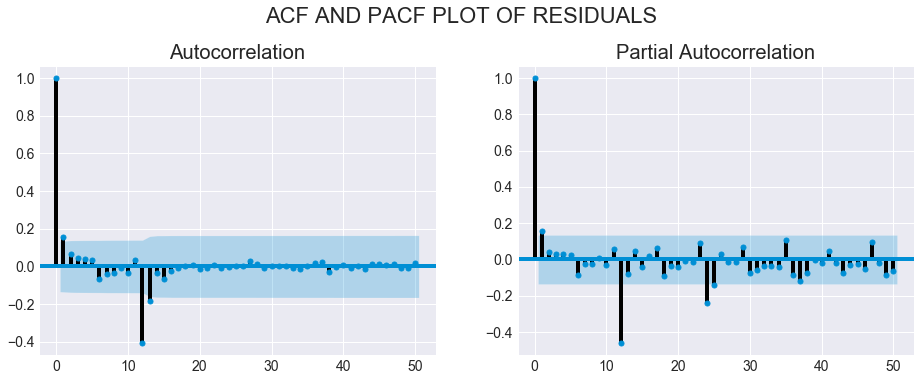

In [95]:
res = arima.resid
fig,ax = plt.subplots(1,2,figsize=(14,5))
plt.suptitle('ACF AND PACF PLOT OF RESIDUALS', fontsize=22, x=0.5, y=1.04)
fig = sm.graphics.tsa.plot_acf(res, lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(res, lags=50, ax=ax[1])
plt.show()

We then plot the residuals of the arima model into an ACF and PACF. 

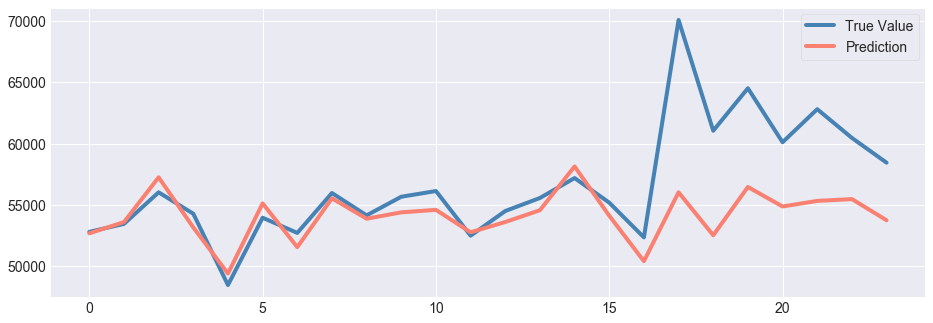

In [96]:
y_val = data.Sales[-24:]
plt.figure(figsize=(14,5))
plt.plot(np.arange(len(y_val)), y_val, color='steelblue');
plt.plot(np.arange(len(y_val)), predictions, color='salmon');
plt.legend(['True Value', 'Prediction']);

In [97]:
arima_mae = mean_absolute_error(y_val, predictions)
arima_mse = mean_squared_error(y_val, predictions)
arima_rmse = np.sqrt(mean_squared_error(y_val, predictions))

print('Mean Absolute Error:   ', arima_mae)
print('Mean Squared Error:   ', arima_mse)
print('Root Mean Squared Error:   ', arima_rmse)

Mean Absolute Error:    2859.670772004563
Mean Squared Error:    20204343.22856623
Root Mean Squared Error:    4494.924162715788


We plot the results of the ARIMA model. We observe that the true value and predicted value are fairly close to each other but fails to capture the big spike in the year of 2020. 

In [98]:
arima_error_rate = abs(((y_val - predictions) / y_val).mean()) * 100
print('MAPE:', round(arima_error_rate,2), '%')

MAPE: 3.94 %


In [99]:
print('R2-SCORE: ', r2_score(y_val, predictions))

R2-SCORE:  0.036480984049189424


We see that the results are faily sound with a MAPE of 3.94% and an R2 score of 0.036.

In [80]:
#extract the date feature
data['day'] = data.Date.dt.day
data['dayofweek'] = data.Date.dt.dayofweek
data['dayofyear'] = data.Date.dt.dayofyear
data['week'] = data.Date.dt.week
data['month'] = data.Date.dt.month
data['year'] = data.Date.dt.year

In [81]:
#add lag feature
for i in range(1,8):
    data['lag'+str(i)] = data.Sales.shift(i).fillna(0)

In [82]:
#drop the date feature
data.drop('Date', axis=1, inplace=True)
#show new data frame
data.head(7)

,Sales,day,dayofweek,dayofyear,week,month,year,lag1,lag2,lag3,lag4,lag5,lag6,lag7
0,31657,1,0,1,1,1,2001,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,29913,1,3,32,5,2,2001,31657.0,0.0,0.0,0.0,0.0,0.0,0.0
2,33084,1,3,60,9,3,2001,29913.0,31657.0,0.0,0.0,0.0,0.0,0.0
3,31911,1,6,91,13,4,2001,33084.0,29913.0,31657.0,0.0,0.0,0.0,0.0
4,34154,1,1,121,18,5,2001,31911.0,33084.0,29913.0,31657.0,0.0,0.0,0.0
5,33317,1,4,152,22,6,2001,34154.0,31911.0,33084.0,29913.0,31657.0,0.0,0.0
6,33437,1,6,182,26,7,2001,33317.0,34154.0,31911.0,33084.0,29913.0,31657.0,0.0


In [101]:
X = data.drop('Sales', axis=1)
y = data.Sales

X_train, X_test = X[:-24], X[-24:]
y_train, y_test = y[:-24], y[-24:]

print('X_train: ', X_train.shape)
print('y_train: ', y_train.shape)
print('X_test: ', X_test.shape)
print('y_test: ', y_test.shape)

X_train:  (213, 13)
y_train:  (213,)
X_test:  (24, 13)
y_test:  (24,)


We apply the same spliting to the xgboost model, where we edit out the last 24month's sales data and predict it. 

In [102]:
#convert data to xgb matrix form
dtrain = xgb.DMatrix(X_train,label=y_train)
dtest = xgb.DMatrix(X_test)

In [103]:
#bayesian hyper parameter tuning
#define the params
def xgb_evaluate(max_depth, gamma, colsample_bytree):
    params = {'eval_metric': 'rmse',
              'max_depth': int(max_depth),
              'subsample': 0.8,
              'eta': 0.1,
              'gamma': gamma,
              'colsample_bytree': colsample_bytree}
    
    cv_result = xgb.cv(params, dtrain, num_boost_round=250, nfold=3)    
    return -1.0 * cv_result['test-rmse-mean'].iloc[-1]

In [104]:
#run optimizer
xgb_bo = BayesianOptimization(xgb_evaluate, {'max_depth': (3, 7), 
                                             'gamma': (0, 1),
                                             'colsample_bytree': (0.3, 0.9)})
#define iter points
xgb_bo.maximize(init_points=10, n_iter=15, acq='ei')

|   iter    |  target   | colsam... |   gamma   | max_depth |
-------------------------------------------------------------
|  1        | -1.152e+0 |  0.4969   |  0.9572   |  3.907    |
|  2        | -1.188e+0 |  0.4803   |  0.9182   |  4.882    |
|  3        | -1.149e+0 |  0.8058   |  0.6737   |  4.047    |
|  4        | -1.113e+0 |  0.3546   |  0.7843   |  3.296    |
|  5        | -1.196e+0 |  0.6063   |  0.3776   |  5.628    |
|  6        | -1.181e+0 |  0.3634   |  0.6182   |  5.958    |
|  7        | -1.205e+0 |  0.6582   |  0.2941   |  6.811    |
|  8        | -1.15e+03 |  0.3196   |  0.7081   |  4.049    |
|  9        | -1.132e+0 |  0.8956   |  0.9021   |  3.836    |
|  10       | -1.185e+0 |  0.6748   |  0.6319   |  5.842    |
|  11       | -1.121e+0 |  0.4048   |  0.7727   |  3.305    |
|  12       | -1.113e+0 |  0.3139   |  0.7803   |  3.269    |
|  13       | -1.113e+0 |  0.3276   |  0.7846   |  3.271    |
|  14       | -1.113e+0 |  0.3263   |  0.8054   |  3.337    |
|  15   

In [105]:
#get the best parameters
params = xgb_bo.max['params']
params['max_depth'] = int(round(params['max_depth']))
#train the data
model = xgb.train(params, dtrain, num_boost_round=200)

In [106]:
#predict the test data 
predictions = model.predict(dtest)

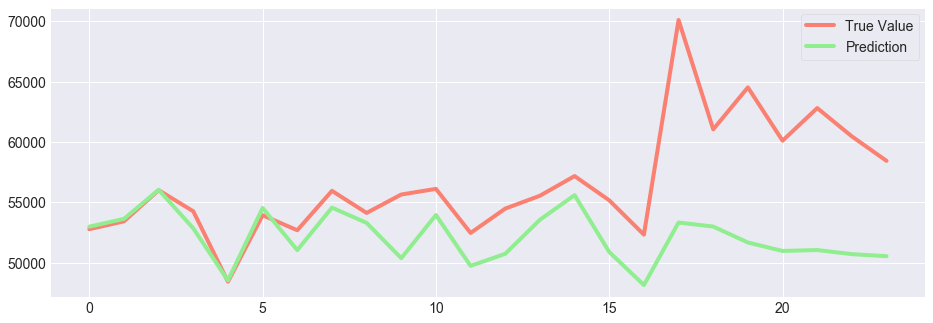

In [108]:
y_val = data.Sales[-24:]
plt.figure(figsize=(14,5))
sns.set_style('darkgrid')
plt.plot(np.arange(len(y_val)), y_val, color='salmon');
plt.plot(np.arange(len(y_val)), predictions, color='lightgreen');
plt.legend(['True Value', 'Prediction']);

In [109]:
xgb_mae = mean_absolute_error(y_val, predictions)
xgb_mse = mean_squared_error(y_val, predictions)
xgb_rmse = np.sqrt(mean_squared_error(y_val, predictions))

print('Mean Absolute Error:   ', xgb_mae)
print('Mean Squared Error:   ', xgb_mse)
print('Root Mean Squared Error:   ', xgb_rmse)

Mean Absolute Error:    4517.074869791667
Mean Squared Error:    41308288.74306234
Root Mean Squared Error:    6427.152459920516


In [110]:
xgb_error_rate = abs(((y_val - predictions) / y_val).mean()) * 100
print('MAPE:', round(xgb_error_rate,2), '%')

MAPE: 7.31 %


In [111]:
print('R2-SCORE: ', r2_score(y_val, predictions))

R2-SCORE:  -0.9699389022481881


The xgboost model does not perform as well as the ARIMA model. The MAPE is 7.31% and R2 score is -0.96.

In [112]:
#function that can generate a monte carlo simulation    
def monte_carlo_simulation(data,t_intervals ,iteration , figsize = (10,4), lw=1):
    from scipy.stats import norm

    #log returns of data
    log_returns = np.log(1 + data.pct_change())

    #Setting up the drift and random component
    mean_  = log_returns.mean()
    var = log_returns.var()
    stdev = log_returns.std()
    drift = mean_ - (0.5 *var)

    daily_returns = np.exp(drift + stdev * norm.ppf(np.random.rand(t_intervals, iteration)))

    S0 = data.iloc[-1]
    #Empty daily returns
    price_list = np.zeros_like(daily_returns)
    price_list[0] = S0

    #appliying montecarlo simulation
    for i in range(1 , t_intervals):
        price_list[i] = price_list[i-1] * daily_returns[i]
    fig_title = str(t_intervals)+ ' DAYS SIMULATION WITH ' +str(iteration)+' DIFFERENT POSSIBILITIES'
    #Show the result of 30 days simulation
    plt.figure(figsize=figsize)
    plt.plot(price_list, lw=lw)
    plt.title(fig_title)
    plt.xlabel('Interval', fontsize=16)
    plt.ylabel('Value', fontsize=16)

Next we try to forecast the price of the sales for the next 24 months using Monte Carlo simulation. 

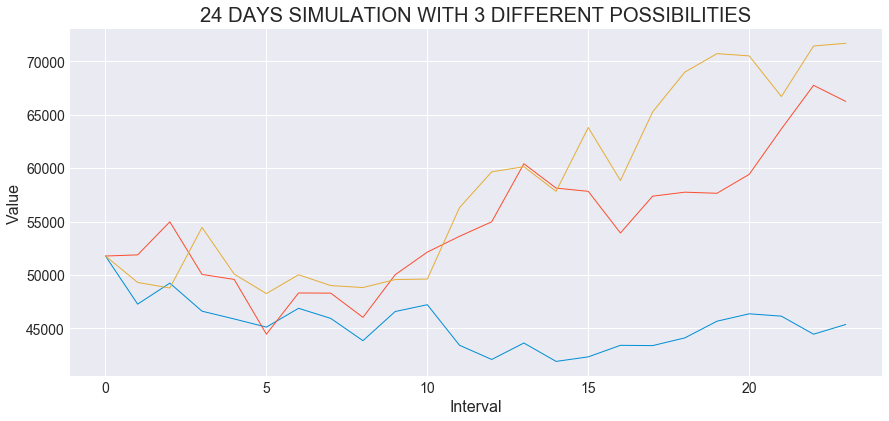

In [113]:
#fit the X_train and show the figure
monte_carlo_simulation(y_train,24,3, figsize=(13,6))